# Chapter 19: Rosenbaum-Style p-Values for Matched Observational Studies with Unobserved Confounding

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

# viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

font = {"family": "IBM Plex Sans Condensed", "weight": "normal", "size": 10}
plt.rc("font", **font)
plt.rcParams["figure.figsize"] = (10, 10)
%matplotlib inline

from utils import *

np.random.seed(42)
%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions

matplotlib       : 3.7.2
scipy            : 1.11.1
statsmodels      : 0.14.0
pandas           : 2.0.3
seaborn          : 0.13.0
graphviz         : 0.20.1
numpy            : 1.24.3
matplotlib_inline: 0.1.6



In [56]:
dat = pd.read_table("cps1re74.csv", sep="\s+")
dat["u74"] = (dat["re74"] == 0).astype(int)
dat["u75"] = (dat["re75"] == 0).astype(int)
y, z = dat.re78.values, dat.treat.values
X = dat[
    [
        "age",
        "educ",
        "black",
        "hispan",
        "married",
        "nodegree",
        "re74",
        "re75",
        "u74",
        "u75",
    ]
].values

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

matches = (
    NearestNeighbors(n_neighbors=1)
    .fit(X[z == 0, :])
    .kneighbors(X[z == 1, :], n_neighbors=1, return_distance=False)
)

In [119]:
ytreated, yctrl = y[z == 1], y[z == 0][matches.flatten()]
datamatched = np.c_[ytreated, yctrl]
matched_means = datamatched.mean(axis=0)
matched_means[0] - matched_means[1]

1521.376503243242

In [112]:
# run sensitivity analysis in R
import rpy2.robjects as ro

sens = ro.packages.importr("sensitivitymw")
ro.numpy2ri.activate()

Gamma = np.arange(1, 1.4, 0.001)
Pvalue = [sens.senmw(datamatched, gamma)[0][0] for gamma in Gamma]

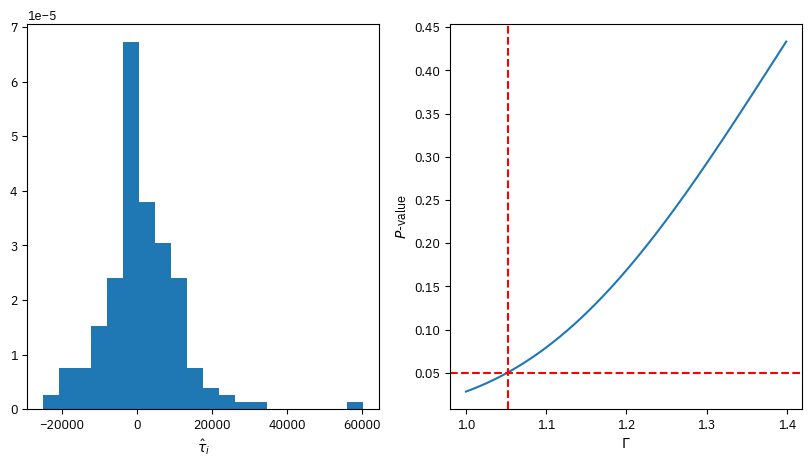

In [116]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(ytreated - yctrl, bins=20, density=True)
ax[0].set_xlabel(r"$\hat{\tau}_i$")

ax[1].plot(Gamma, Pvalue)
ax[1].set_xlabel(r"$\Gamma$")
ax[1].set_ylabel(r"$P$-value")
ax[1].axhline(0.05, color="red", linestyle="--")
ax[1].axvline(Gamma[np.array(Pvalue) >= 0.05][0], color="red", linestyle="--")

In [101]:
res[0]

array([0.07943202])